# Sentinel-1 SAR Change Detection and Time Series Analysis over Mar Menor Agricultural Areas

This notebook analyses Sentinel-1 SAR (VV/VH) backscatter to detect and quantify agricultural change in the Mar Menor region (SE Spain).
It computes median composites for two summer seasons (2017 and 2024), derives a VH difference image, classifies significant increases and decreases, and summarizes area per class (hectares).
A monthly VH time series for a sample parcel is also generated and plotted. Outputs include an area summary, a time-series plot, and an interactive map layer.
Requirements: authenticated Google Earth Engine account and geemap installed for interactive mapping. Run the cells sequentially and expect remote calls (reduceRegion / getInfo) to take time.

In [4]:
# Imports and Earth Engine initialization
import ee
import geemap
import folium
import matplotlib.pyplot as plt
import pandas as pd

# Initialize the Earth Engine API (authenticate if needed)
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# Define the area of interest (Mar Menor bounding rectangle) and comparison periods
mar_menor_aoi = ee.Geometry.Rectangle([-1.05, 37.58, -0.70, 37.90]) # This can be adjusted as needed, I recommend using a more precise polygon for actual analysis

# Define time periods for comparison
period1_start = '2017-06-01'
period1_end = '2017-08-31'
period2_start = '2024-06-01'
period2_end = '2024-08-31'


### Collection preparation and edge masking
Create the Sentinel-1 collection for the AOI (VV/VH, IW) and apply a fast edge mask that removes pixels below -30 dB to exclude border artefacts that can bias composites; you can check the collection size after running and adjust the threshold or use incidence-angle masks if needed.

In [5]:
def mask_edge(image):
    """Mask extreme negative values often found at image borders."""
    edge = image.lt(-30.0)
    masked = image.mask().And(edge.Not())
    return image.updateMask(masked)

# Base Sentinel-1 collection filtered for the AOI and polarizations
sentinel1_base = (ee.ImageCollection('COPERNICUS/S1_GRD')
                .filterBounds(mar_menor_aoi)
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.eq('instrumentMode', 'IW'))
                .map(mask_edge))


### Median composites and VH difference
Compute a median composite for each period to reduce speckle and remove outliers; median stabilizes per-pixel values across multiple acquisitions. Extract the VH band and subtract period1 from period2 to produce a dB change image that highlights increases or decreases in vegetation/biomass or moisture. Water pixels (VH < -22 dB) are masked to avoid water-driven differences. After running, inspect the median composites and a few sample pixels to validate the signal and adjust compositing method, thresholds, or scale if needed.

In [6]:
# Median composites for each period clipped to AOI
median_p1 = sentinel1_base.filterDate(period1_start, period1_end).median().clip(mar_menor_aoi)
median_p2 = sentinel1_base.filterDate(period2_start, period2_end).median().clip(mar_menor_aoi)

# VH difference (period2 - period1)
change_vh = median_p2.select('VH').subtract(median_p1.select('VH'))

# Mask obvious water pixels from the second-period VH composite to avoid water-driven changes
water_mask = median_p2.select('VH').lt(-22)
change_vh_masked = change_vh.updateMask(water_mask.Not())


### Area quantification (change classification)
We classify the VH change into three classes and compute area (hectares) per class. Thresholds are tuned heuristically, expertise from an expert could help tune the thresholds to achieve a better output.

In [7]:
# Thresholds (dB) - adjust if needed
threshold_increase = 2.5
threshold_decrease = -2.5

# 0: no-data, 1: increase, 2: decrease, 3: stable
change_classified = ee.Image(0)
change_classified = change_classified.where(change_vh_masked.gt(threshold_increase), 1)
change_classified = change_classified.where(change_vh_masked.lt(threshold_decrease), 2)
change_classified = change_classified.where((change_vh_masked.gte(threshold_decrease)).And(change_vh_masked.lte(threshold_increase)), 3)
change_classified = change_classified.updateMask(change_vh_masked.mask())

# Pixel area in hectares
pixel_area_ha = ee.Image.pixelArea().divide(10000)
# Multiply area by class mask and group-sum
area_by_class = pixel_area_ha.addBands(change_classified).reduceRegion(
    reducer=ee.Reducer.sum().group(groupField=1, groupName='class'),
    geometry=mar_menor_aoi,
    scale=30,
    maxPixels=1e9
)

# Retrieve results from the server
stats = area_by_class.getInfo().get('groups', [])
area_increase_ha = 0
area_decrease_ha = 0
area_stable_ha = 0
for g in stats:
    if g['class'] == 1:
        area_increase_ha = g['sum']
    elif g['class'] == 2:
        area_decrease_ha = g['sum']
    elif g['class'] == 3:
        area_stable_ha = g['sum']

print('--- AGRICULTURAL CHANGE SUMMARY (2017 vs 2024) ---')
print(f'Area with significant INCREASE: {area_increase_ha:.2f} ha')
print(f'Area with significant DECREASE: {area_decrease_ha:.2f} ha')
print(f'Area classified as STABLE: {area_stable_ha:.2f} ha')
print('-------------------------------------------------')


--- AGRICULTURAL CHANGE SUMMARY (2017 vs 2024) ---
Area with significant INCREASE: 5937.22 ha
Area with significant DECREASE: 4932.37 ha
Area classified as STABLE: 55668.74 ha
-------------------------------------------------


### Time series over a sample parcel
Compute monthly median VH over a selected parcel to reduce noise and capture seasonal and interannual trends; plotting the monthly mean VH helps track changes in vegetation or moisture. This step may take time (server-side aggregation for large data) and benefits from choosing a representative parcel and checking for gaps or outliers in the feature collection before plotting.

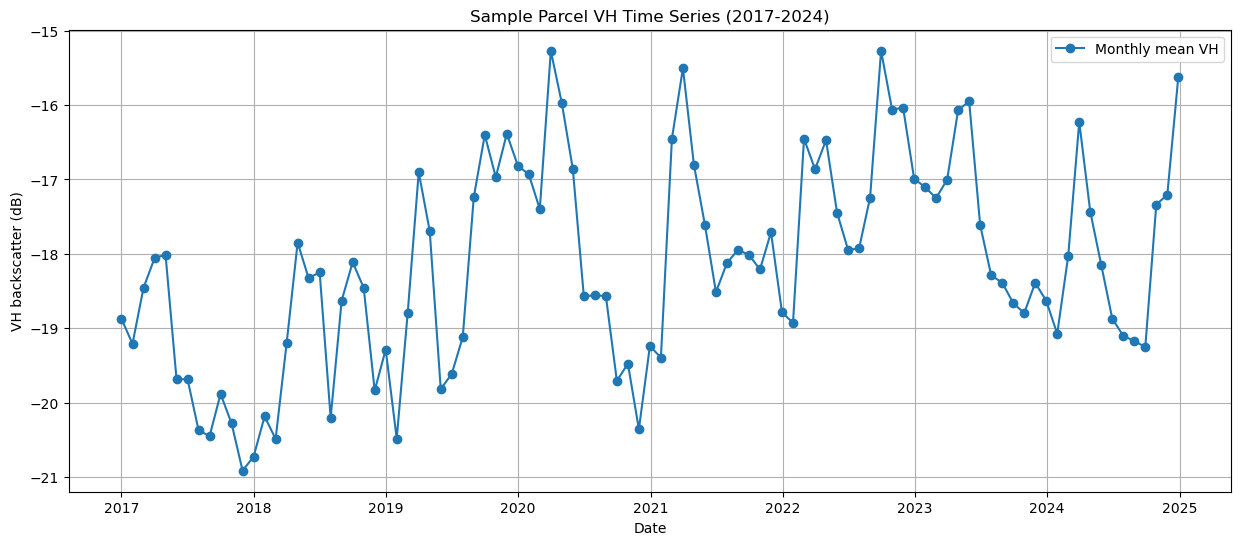

In [ ]:
# Example parcel polygon (choose your own coordinates)
sample_parcel = ee.Geometry.Polygon([
    [-0.9302157134565646, 37.67833465302895],
    [-0.9202852855986137, 37.67995055764423],
    [-0.9207796852001492, 37.677665589943736],
    [-0.9296869034665399, 37.676065804096105],
    [-0.9302157134565646, 37.67833465302895]
])

# Monthly median collection range
complete_collection = sentinel1_base.filterDate('2017-01-01', '2024-12-31')

def monthly_feature(date):
    d = ee.Date(date)
    monthly = complete_collection.filterDate(d, d.advance(1, 'month')).median()
    mean_vh = monthly.reduceRegion(reducer=ee.Reducer.mean(), geometry=sample_parcel, scale=30).get('VH')
    return ee.Feature(None, {'system:time_start': d.millis(), 'VH_mean': mean_vh})

# Build the monthly sequence (approx. 30.4 days per month in ms)
months = ee.List.sequence(ee.Date('2017-01-01').millis(), ee.Date('2024-12-31').millis(), 1000 * 60 * 60 * 24 * 30.4)
time_series_fc = ee.FeatureCollection(months.map(monthly_feature))

# Fetch results (may take some time)
ts_info = time_series_fc.getInfo()
dates = [pd.to_datetime(f['properties']['system:time_start'], unit='ms') for f in ts_info['features']]
vh_values = [f['properties']['VH_mean'] for f in ts_info['features']]

plt.figure(figsize=(15, 6))
plt.plot(dates, vh_values, marker='o', linestyle='-', label='Monthly mean VH')
plt.grid(True)
plt.title('Sample Parcel VH Time Series (2017-2024)')
plt.xlabel('Date')
plt.ylabel('VH backscatter (dB)')
plt.legend()
plt.show()


### Map visualization
Display the classified change (masked) and the sample parcel on an interactive map.

In [9]:
change_vis_params = {'min': -5, 'max': 5, 'palette': ['FF0000', 'FFFFFF', '00FF00']}
map_center = [37.75, -0.85]
m_final = geemap.Map(center=map_center, zoom=11, height='800px', width='100%')
m_final.addLayer(change_vh_masked, change_vis_params, 'Agricultural change (2017 vs 2024)')
m_final.addLayer(sample_parcel, {'color': 'yellow'}, 'Sample parcel for time series')
m_final.addLayerControl()
display(m_final)

Map(center=[37.75, -0.85], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright'…